In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import json
import functions as f

In [50]:
PATH = 'realKnownCause/rogue_agent_key_hold.csv'
ERRORPATH = 'labels/combined_windows.json'
df = pd.read_csv(PATH,  parse_dates=['timestamp'])
with open(ERRORPATH, "r") as file:
    errors = json.load(file)
df_error = errors.get(PATH)

In [51]:
time_dff, df = f.process_time_series(df, grouping=True)
df['value_min'] = df['value_min'].interpolate(method='linear') 

# Convert error windows to datetime
#error_windows = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in df_error]
#df['outlier'] = df['timestamp'].apply(lambda x: f.is_outlier(x, error_windows))

In [52]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['value_min'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}; p-value < 0.05: {result[1] < 0.05}')

ADF Statistic: -4.967647652514303
p-value: 2.5708622357982178e-05; p-value < 0.05: True


In [54]:
df.set_index('timestamp', inplace=True)

In [90]:
df_30min = df.resample('15min').agg({
    'value_min': ['min', 'max', 'mean']
}).reset_index()

# Flatten the MultiIndex columns
df_30min.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_30min.columns.values]

# Display the first 10 rows
df_30min.head()

,timestamp,value_min_min,value_min_max,value_min_mean
0,2014-07-06 20:00:00,0.064535,0.064535,0.064535
1,2014-07-06 20:15:00,0.063880,0.065692,0.064622
2,2014-07-06 20:30:00,0.056301,0.067751,0.061683
3,2014-07-06 20:45:00,0.000000,0.065288,0.032644
4,2014-07-06 21:00:00,0.000000,0.063179,0.021060


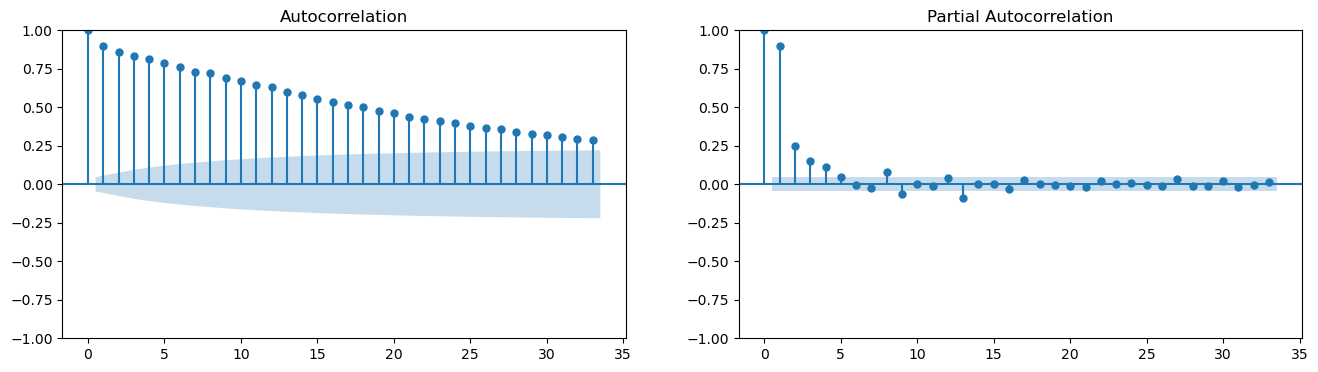

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8375.717, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8141.830, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8291.136, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8359.368, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8143.830, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8377.232, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8378.707, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-8377.888, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8379.263, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8377.598, Time=0.58 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8344.278, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8380.212, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-8361.368, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8293.136, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0

In [114]:
from pmdarima import auto_arima

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(df_30min['value_min_mean'].dropna(), ax=axes[0])
plot_pacf(df_30min['value_min_mean'].dropna(), ax=axes[1])
plt.show()

# Use auto_arima to find the best order
auto_model = auto_arima(df_30min['value_min_mean'], seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)
print(auto_model.summary())
print('Best ARIMA order is: ', auto_model.order)

In [115]:
df_30min['outlier'] = df_30min['timestamp'].apply(lambda x: f.is_outlier(x, error_windows))
best_order = auto_model.order
mean_values = df_30min['value_min_mean'].dropna()

In [116]:
from statsmodels.tsa.arima.model import ARIMA

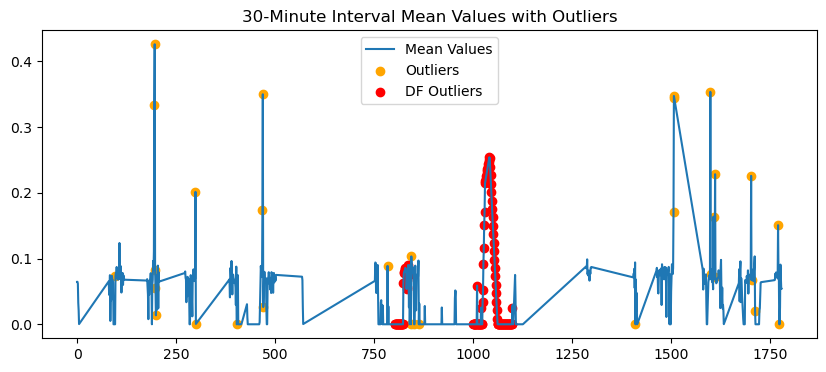

In [119]:
# Fit the ARIMA model
model = ARIMA(mean_values, order=best_order)
model_fit = model.fit()

# Forecast the values
forecast = model_fit.fittedvalues

# Calculate residuals
residuals = mean_values - forecast

# Calculate the standard deviation of the residuals
std_residuals = np.std(residuals)

# Identify outliers (e.g., residuals more than 3 standard deviations from the mean)
outliers = np.abs(residuals) > 3 * std_residuals

# Plot the mean values and highlight outliers
plt.figure(figsize=(10, 4))
plt.plot(mean_values, label='Mean Values')
plt.scatter(mean_values.index[outliers], mean_values[outliers], color='orange', label='Outliers')
plt.scatter(df_30min.index[df_30min['outlier']==1], df_30min['value_min_mean'][df_30min['outlier']==1], color='red', label='DF Outliers')
plt.title('30-Minute Interval Mean Values with Outliers')
plt.legend()
plt.show()

In [106]:
std_residuals

0.022934576209213835